# Segmentation

### C++ opencv

returncode = 0
stdout:
 [ INFO:0@0.207] global registry_parallel.impl.hpp:96 cv::parallel::ParallelBackendRegistry::ParallelBackendRegistry core(parallel): Enabled backends(3, sorted by priority): ONETBB(1000); TBB(990); OPENMP(980)
[ INFO:0@0.208] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.212] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_onetbb4120_64d.dll => FAILED
[ INFO:0@0.212] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv_core_parallel_tbb4120_64d.dll => FAILED
[ INFO:0@0.215] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load opencv_core_parallel_tbb4120_64d.dll => FAILED
[ INFO:0@0.215] global plugin_loader.impl.hpp:67 cv::plugin::impl::DynamicLib::libraryLoad load C:\opencv\build\x64\vc16\bin\opencv

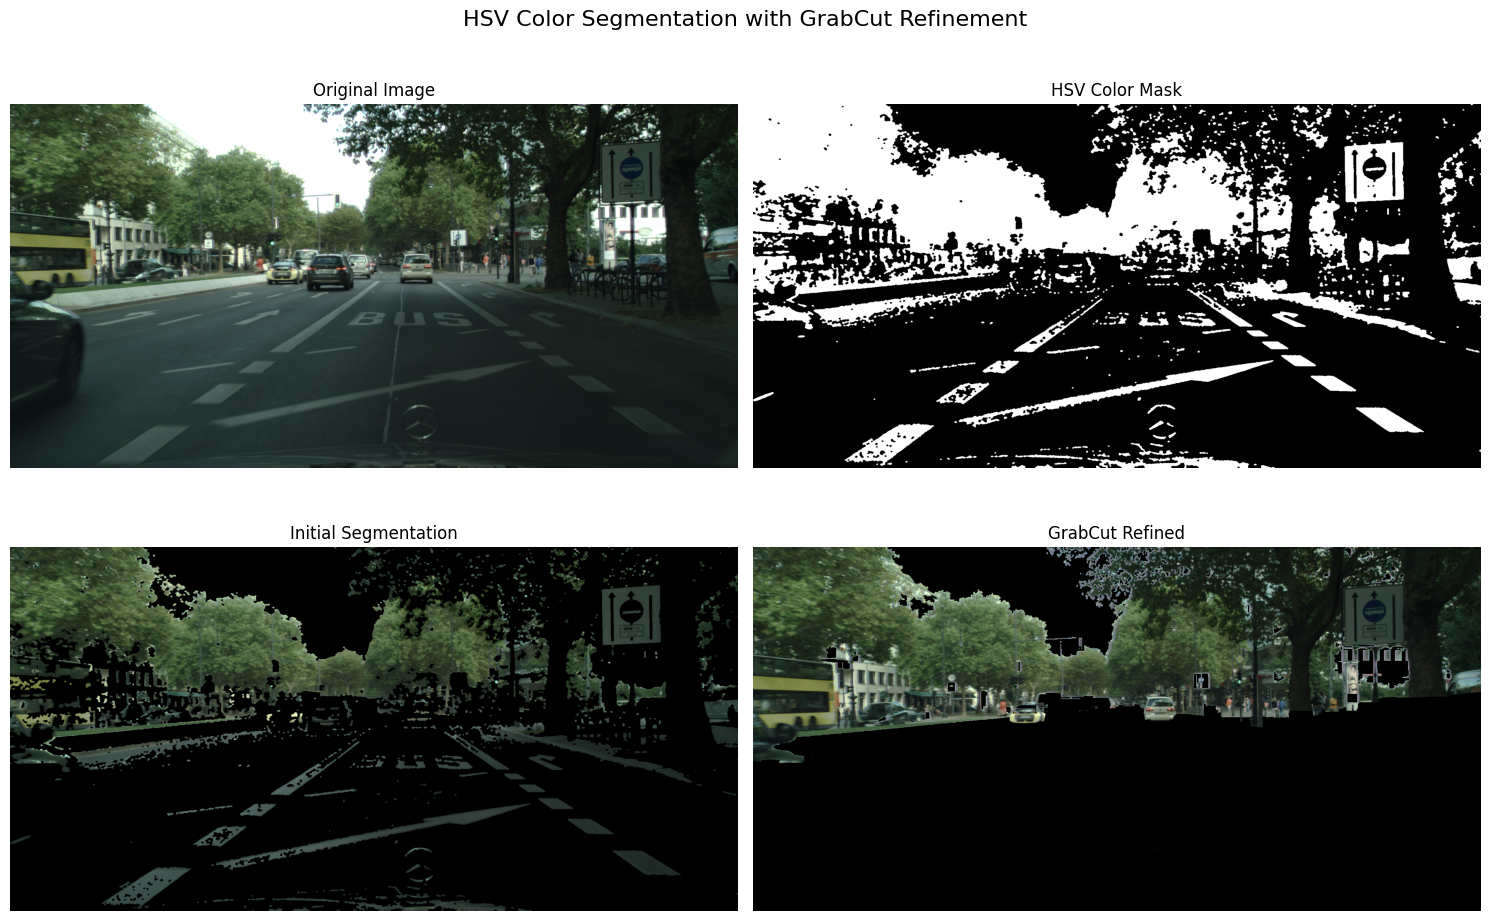

In [1]:
import subprocess, sys, shutil, os
exe_path = os.path.join('..', 'build', 'Debug', 'segmentation.exe')
if os.path.exists(exe_path):
    # Run the segmentation executable with --no-gui flag to avoid GUI dependencies
    proc = subprocess.run([exe_path, '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png', '--no-gui'], 
                         capture_output=True, text=True)
    print('returncode =', proc.returncode)
    print('stdout:\n', proc.stdout)
    print('stderr:\n', proc.stderr)
    
    if proc.returncode == 0:
        from PIL import Image
        import matplotlib.pyplot as plt
        
        out_dir = 'out_images'
        segmentation_imgs = [
            'segmentation_original.png',
            'segmentation_mask.png', 
            'segmentation_result.png',
            'grabcut_result.png'
        ]
        
        titles = [
            'Original Image',
            'HSV Color Mask', 
            'Initial Segmentation',
            'GrabCut Refined'
        ]
        
        plt.figure(figsize=(15,10))
        for i, (name, title) in enumerate(zip(segmentation_imgs, titles), 1):
            path = os.path.join(out_dir, name)
            if os.path.exists(path):
                im = Image.open(path).convert('RGB')
                plt.subplot(2,2,i)
                plt.imshow(im)
                plt.title(title)
                plt.axis('off')
            else:
                print(f"Image not found: {path}")
        
        plt.suptitle('HSV Color Segmentation with GrabCut Refinement', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # # Also show the transform results if they exist
        # transform_imgs = ['original.png','grayscale.png','gaussian_blur.png','canny_edges.png','resized.png','rotated.png','perspective.png','hsv.png','flipped.png']
        # existing_transforms = [img for img in transform_imgs if os.path.exists(os.path.join(out_dir, img))]
        
        # if existing_transforms:
        #     plt.figure(figsize=(12,8))
        #     for i, name in enumerate(existing_transforms, 1):
        #         path = os.path.join(out_dir, name)
        #         im = Image.open(path).convert('RGB')
        #         plt.subplot(3,3,i)
        #         plt.imshow(im)
        #         plt.title(name.replace('.png', '').replace('_', ' ').title())
        #         plt.axis('off')
        #     plt.suptitle('Image Transformations', fontsize=16)
        #     plt.tight_layout()
        #     plt.show()
    else:
        print(f"Segmentation failed with return code {proc.returncode}")
else:
    print('Executable not found at', exe_path)
    print('Please build the project first using: cmake --build build --config Debug')

### Python opencv

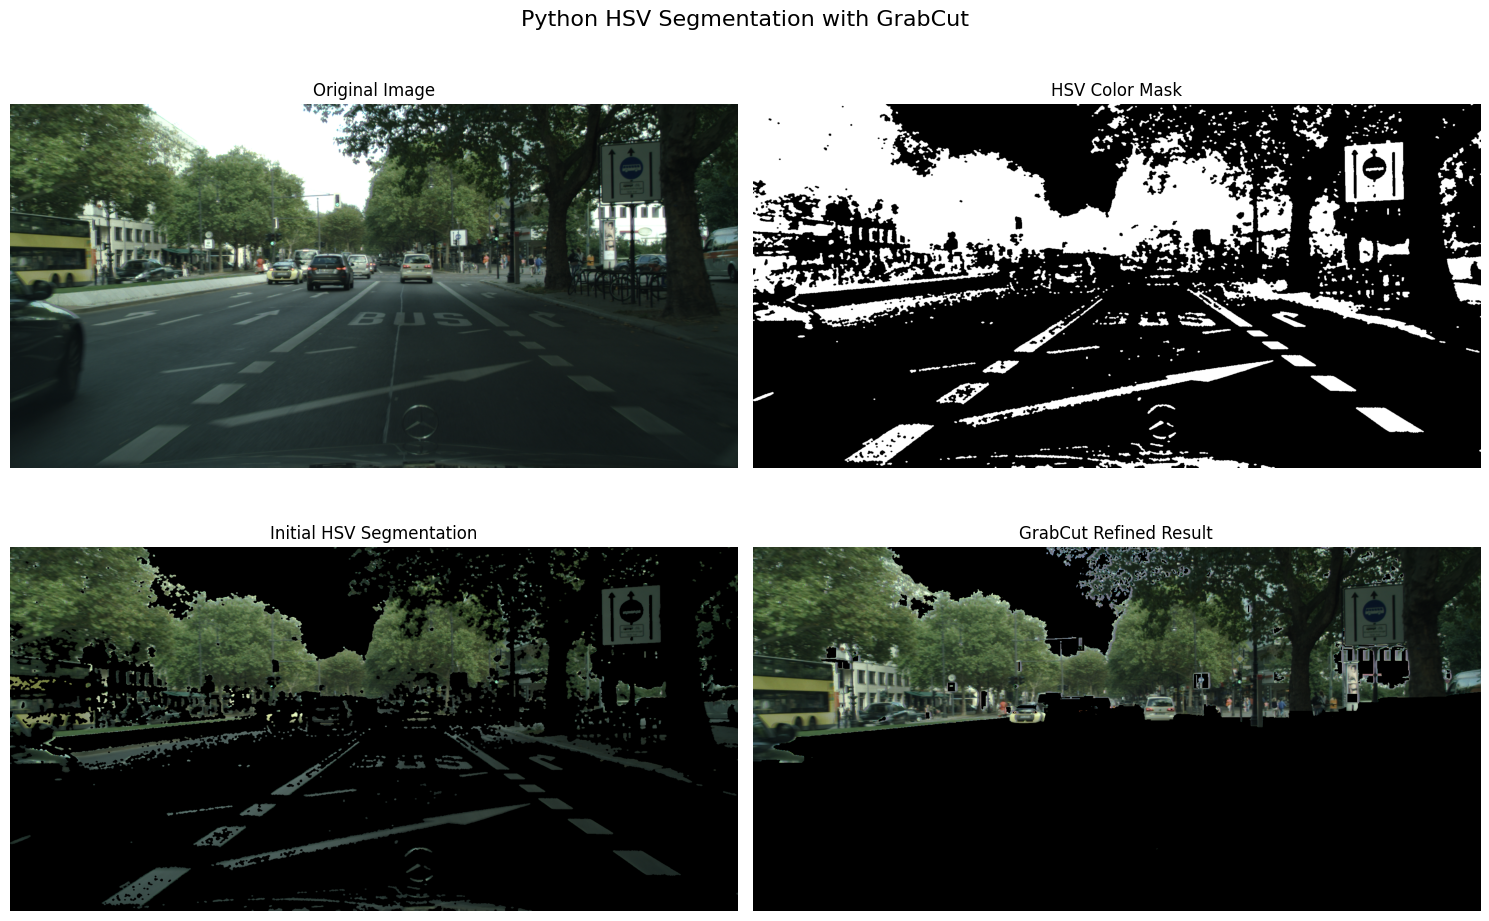

Python segmentation complete!


In [ ]:
# Python implementation of HSV segmentation with GrabCut
import cv2
import numpy as np
import matplotlib.pyplot as plt

def hsv_segmentation_with_grabcut(img_path):
    """
    Perform HSV color segmentation followed by GrabCut refinement
    """
    # Load image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Could not load image {img_path}")
        return
    
    # Convert to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for green-ish objects (same as C++ code)
    lower = np.array([35, 40, 40])
    upper = np.array([85, 255, 255])
    
    # Create initial mask
    mask = cv2.inRange(hsv, lower, upper)
    
    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Apply initial mask
    initial_result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    
    # Prepare GrabCut
    grabcut_mask = np.zeros(mask.shape, np.uint8)
    grabcut_mask[mask == 255] = cv2.GC_PR_FGD  # Probable foreground
    grabcut_mask[mask == 0] = cv2.GC_PR_BGD    # Probable background
    
    # Initialize models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Define rectangle (slightly smaller than image)
    rect = (1, 1, img.shape[1]-2, img.shape[0]-2)
    
    # Apply GrabCut
    cv2.grabCut(img, grabcut_mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)
    
    # Create final mask
    final_mask = np.where((grabcut_mask == cv2.GC_FGD) | (grabcut_mask == cv2.GC_PR_FGD), 255, 0).astype('uint8')
    
    # Apply Final mask
    grabcut_result = cv2.bitwise_and(img_rgb, img_rgb, mask=final_mask)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('HSV Color Mask')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(initial_result)
    axes[1, 0].set_title('Initial HSV Segmentation')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(grabcut_result)
    axes[1, 1].set_title('GrabCut Refined Result')
    axes[1, 1].axis('off')
    
    plt.suptitle('Python HSV Segmentation with GrabCut', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return img_rgb, mask, initial_result, grabcut_result

if __name__ == "__main__":
    img_path = '../dataset/leftImg8bit_trainvaltest/test/berlin/berlin_000000_000019_leftImg8bit.png'
    if os.path.exists(img_path):
        results = hsv_segmentation_with_grabcut(img_path)
        print("Python segmentation complete!")
    else:
        print(f"Image not found: {img_path}")
        print("Please make sure the dataset is available.")